In [42]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from math import sqrt

#plots
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel

# sklearn
from sklearn.svm import LinearSVC
from sklearn.exceptions import DataConversionWarning; import warnings
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV

In [279]:
# load data
data = pd.read_csv('part2.csv')
data = data[data['Preprocces Title'].notna()]
data = data.reset_index()

In [280]:
data['x_cat'] = data['url'].str.replace('https://ekstrabladet.dk/nyheder/','')
data['x_cat'] = data['x_cat'].str.replace('https://ekstrabladet.dk/','')
data['x_cat'] = data['x_cat'].apply(lambda x: x.split('/')[0])

In [281]:
len(data['body'])

24031

In [282]:
len_title = []
len_body = []
for i in data['title']:
    len_title.append(len(i))
data['len_title'] = pd.DataFrame(data=len_title)

In [283]:
n = 10
data['comments_cat'] = pd.qcut(data.comments, n, labels=list(range(n)))

In [284]:
len(data[data.comments_cat==2])

2325

In [285]:
data['set'] = 'hi'

In [286]:
n = len(data['set'])
if n%2 !=0:
    n -= 1
n1 = int(n/2)
n

24030

In [287]:
data['set'][:n1] = 'test'
data['set'][n1:n] = 'train'

C:\Users\Jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [288]:
df_train = data[data.set=="train"]
df_test = data[data.set=="test"]

In [120]:
df_test_word = df_test[df_test.proc_title_rm=='dårligt']

In [121]:
df_test_word

,level_0,index,url,comments,title,subtitle,body,date,proc_title,proc_title_rm,comments_cat,set
2,2,2,https://ekstrabladet.dk/flash/filmogtv/daarlig...,34,Dårligt nyt til 'Venner'-fans,NaN,Der var gode nyheder til fans af serien 'Frien...,7. aug. 2020,"['dårligt', 'nyt', 'vennerfans']",dårligt,4,test
228,983,983,https://ekstrabladet.dk/flash/filmogtv/daarlig...,34,Dårligt nyt: Udskyder et helt år,"Ventede film som ""Avatar 2"" og ""Star Wars"" får...","Allerede før, 'Avatar' havde premiere i 2009, ...",24. jul. 2020,"['dårligt', 'nyt', 'udskyder', 'helt', 'år']",dårligt,4,test
338,1476,1476,https://ekstrabladet.dk/sport/fodbold/udenland...,0,Dårligt nyt for Arsenal: Stortalent ude resten...,Gabriel Martinelli er blevet opereret i knæet ...,Det lovende offensivtalent Gabriel Martinelli ...,17. jul. 2020,"['dårligt', 'nyt', 'arsenal', 'stortalent', 'u...",dårligt,0,test
996,4571,4571,https://ekstrabladet.dk/sport/fodbold/udenland...,17,Dårligt nyt til Braithwaite,Det ser igen svært ud for Martin Braithwaites ...,I denne uge er Barcelonas trup tilbage på træn...,5. jun. 2020,"['dårligt', 'nyt', 'braithwaite']",dårligt,3,test
1169,5316,5316,https://ekstrabladet.dk/sport/fodbold/udenland...,18,Udgik med blodtud: Dårligt nyt til dansk stjerne,Chelsea-manager Frank Lampard føler for Andrea...,Chelseas danske forsvarsspiller Andreas Christ...,18. feb. 2020,"['udgik', 'blodtud', 'dårligt', 'nyt', 'dansk'...",dårligt,3,test
1170,5325,5325,https://ekstrabladet.dk/sport/fodbold/udenland...,13,Dårligt EM-nyt: Kjær skadet,Landsholdsanfører Simon Kjær blev skadet i før...,AC Milan rejste sig fra 2-4-nederlaget i lokal...,17. feb. 2020,"['dårligt', 'emnyt', 'kjær', 'skad']",dårligt,2,test
1248,5664,5664,https://ekstrabladet.dk/sport/fodbold/dansk_fo...,162,Dårligt nyt for FCK: Fischer må holde pause,Viktor Fischer blev skadet på FC Københavns tr...,"FC København oplyser, at Viktor Fischer er ble...",12. feb. 2020,"['dårligt', 'nyt', 'fck', 'fischer', 'må', 'ho...",dårligt,8,test
1713,7519,7519,https://ekstrabladet.dk/sport/fodbold/udenland...,92,Dårligt nyt for Eriksen: Problemer med forhand...,NaN,Christian Eriksen vil gerne have en ny udfordr...,15. jan. 2020,"['dårligt', 'nyt', 'eriksen', 'problemer', 'fo...",dårligt,7,test
2139,9368,9368,https://ekstrabladet.dk/sport/anden_sport/golf...,7,Dårligt nyt for dansk stjerne,Ifølge en talsmand fra European Tour er Thorbj...,At sagen om Thorbjørn Olesens opførsel på et f...,13. dec. 2019,"['dårligt', 'nyt', 'dansk', 'stjern']",dårligt,2,test
2206,9658,9658,https://ekstrabladet.dk/sport/haandbold/daarli...,22,Dårligt nyt for Danmark: Nu er der maksimalt pres,Danmark skal vinde over Holland for at få muli...,De danske håndboldkvinder må ikke tabe til Hol...,9. dec. 2019,"['dårligt', 'nyt', 'danmark', 'nu', 'maksimalt...",dårligt,3,test


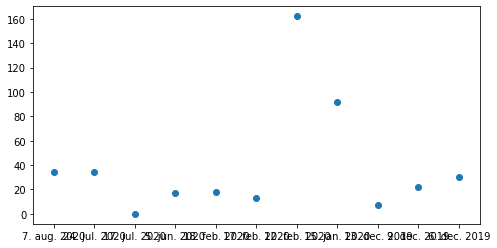

In [127]:
plt.figure(figsize=(8,4))
plt.scatter(df_test_word.date,df_test_word.comments)

In [9]:
vectorizer_test = CountVectorizer()
X = vectorizer.fit_transform(df_train.title.values)

NameError: name 'vectorizer' is not defined

In [10]:
X[]

SyntaxError: invalid syntax (<ipython-input-10-63c3eade6e23>, line 1)

In [11]:
pd.DataFrame.sparse.from_spmatrix(X)

NameError: name 'X' is not defined

In [120]:
X = data['title']
y = data['comments_cat']
# create test, train and dev
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)    
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

In [25]:
X_test_split = [sent.split(' ') for sent in X_test]

In [26]:
# Bag of Words

# CountVectorizer has a build-in tokenizer and lowercases by default. Also has an option to remove stopwords.
vectorizer = CountVectorizer()
# However, you can override the default tokenization with your own defined function, like so:
#vectorizer = CountVectorizer(tokenizer=preprocess)

# fit and transform train
X_train_bow = vectorizer.fit_transform(data.title.values)
# Only tranform test: never fitting your vectorizer on the test set (it is cheating). OOV words are handled automatically be sklearn's vectorizer.
X_test_bow = vectorizer.transform(df_test.title.values)

In [27]:
print(X_train_bow.shape)
print(len(vectorizer.vocabulary_))
X_train_bow[0]

(24031, 21492)
21492


<1x21492 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [13]:
X_train_bow[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
def make_ngrams(sentence,n):
    tokens = sentence.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]


In [13]:
# n=1-5
vectorizer = CountVectorizer(ngram_range=(1,5))

X_train_5gram = vectorizer.fit_transform(df_train.title.values)

In [14]:
print(X_train_5gram.shape)
X_train_5gram[0]

(12000, 198842)


<1x198842 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [15]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train.title.values)

In [16]:
X_train_tfidf[1]

<1x14633 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [17]:
distance.cosine(X_train_tfidf[0].toarray(), X_train_tfidf[1].toarray())

1.0

In [18]:
X_train

1779                              Nu koster det millioner 
23280                             Smag på 200 franske vine
3450                       Kanonmål overrumpler Schmeichel
23605                   Grafik: Forstå spillet om Grønland
9782                 Ekstra Bladet kårer: Årets ældre hest
                               ...                        
18636      Tøfting: Beklager, Bendtner - den går sgu ikke!
2569                                44 år og farmor til to
21693                   Takker nej til Europa efter corona
18490      Derfor døde hun med 885 kilometer i timen i bil
6030     Kæmpe Superliga-salg: Stjerne skifter til Serie A
Name: title, Length: 8010, dtype: object

In [19]:
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
cosine_similarities = linear_kernel(X_train_tfidf[0], X_train_tfidf).flatten()

indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])

most similar: [   0 9564 1509 4847 6535 2061 1915 3559 1588 4086]
least similar [7890 7889 7888 7886 7885 7884 7883 7882 5999]


In [20]:
print(df_train.title.values[0])
print()
print("most similar: ", df_train.title.values[1719])
print()
print("least similar: ", df_train.title.values[7237])

Historisk aftale: Enige om stor lønnedgang

most similar:  Gravid sygeplejerske død med corona: Baby overlever efter akut kejsersnit

least similar:  Scorede vildt hattrick i søndags: Nu er han ude igen


# Vector space models

In [21]:
from gensim.models import Word2Vec

# using the train_sents from earlier (the lowercased and tokenized sentences)
model = Word2Vec(X_test_split, size=100, min_count = 10, workers = 2) 

In [22]:
print(model.wv['Trump'])

[-0.01721106  0.17385447  0.07275034  0.06913579 -0.2762036   0.14498658
 -0.00885505  0.12016932 -0.04960506  0.3739551   0.1282039  -0.09329023
  0.06670989 -0.23785615  0.1334666  -0.29035544  0.0138099  -0.03617769
  0.1654464  -0.16387749  0.2184856   0.04822574  0.07998101 -0.01851439
 -0.06055112 -0.06202332  0.11534135  0.08248831 -0.0344585   0.18873915
 -0.03763665  0.13909805 -0.06011594 -0.04311617  0.11176118  0.33142462
  0.14729992  0.10986831  0.0456105  -0.06590657  0.26615712 -0.06725091
 -0.13969153  0.01558073 -0.04672069 -0.30587986 -0.00708817 -0.1587202
  0.11551663 -0.11246855  0.18503377  0.11943673  0.06302044  0.11655894
  0.09342019  0.10434686  0.04165602  0.03426776 -0.12398967  0.16881539
 -0.13777871 -0.05473946  0.04597635 -0.13323802  0.2927318   0.15455472
 -0.03328773 -0.20586424 -0.04656272 -0.080584    0.04122513  0.28587037
  0.12074148  0.21513444  0.20849444  0.11413496 -0.05053127  0.29584533
 -0.08501224 -0.13092627  0.03076416 -0.2691548   0.

In [23]:
for i, word in enumerate(model.wv.vocab):
    if i == 100:
        break
    print(word)

Venstre
forlader
raser:
Her
bliver
mand
smidt
ud
af
Kæmpe
eller
Schmeichel
og

Fuglsang
det
i
dage
Fans
raser
over
-
ikke
noget
sin
På
vej
Premier
med
EM
uden
tilskuere
er
en
United
ny
nedtur
dansker
blev
den
store
helt
om
Sælger
for
Danske
ved
Mette
F.
Sender
danskere
på
Efter
mod
Tidligere
leder
at
bag
Var
Nu
hun
Corona
dårligt
værste
mange
år
til
spille
Real
fra
Haas
Danmark
største
møde
får
din
et
nyt
Det
voldsomt
by
Zlatan
kvinder
lov
se
Helt
hans
seks
millioner
kroner
Vild
gjorde
vanvittig
ondt
vildt
du
før
tid
Svensk
Kan


In [24]:
model

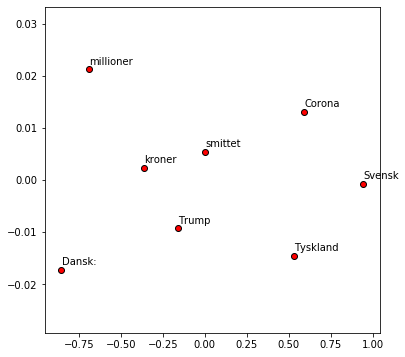

In [25]:
# Reducing the 50-dimensional vectors to 2 dimensions in order to visualise selected words.
from sklearn.decomposition import PCA

words = ['Corona', 'Tyskland', 'Dansk:', 'kroner', 'Trump', 'Svensk', 'millioner', 'smittet']

X = [model.wv['Corona'], model.wv['Tyskland'], 
     model.wv['Dansk'], model.wv['kroner'],
     model.wv['Trump'], model.wv['Svensk'], 
     model.wv['millioner'], model.wv['smittet']]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, X_r):
    plt.text(x+0.002, y+0.001, word)

# model

### Logistic

In [194]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0)),
])

param_grid = {"vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
             "tfidf__use_idf": [True, False]
             }

search_log = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4)

search_log.fit(df_train.x_cat.values, df_train.comments.values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done  20 out of  24 | elapsed:   36.9s remaining:    7.3s
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:   44.5s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [195]:
print('Best parameter set: %s ' % search_log.best_params_)
print('Best mse: %s ' % search_log.best_score_)

Best parameter set: {'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)} 
Best mse: -40389.66536141719 


In [196]:
train_preds_log = search_log.predict(df_train.x_cat.values)
test_preds_log = search_log.predict(df_test.x_cat.values)
print("training accuracy:", np.mean([(train_preds_log==df_train.comments.values)]))
print("testing accuracy:", np.mean([(test_preds_log==df_test.comments.values)]))

training accuracy: 0.08234473133286811
testing accuracy: 0.061409630146545706


### OLS

In [274]:
pipeline_ols = Pipeline([
    #('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('clf', LinearRegression()),
])

param_grid_ols = {#"vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
             #"tfidf__use_idf": [True, False]
            'pol__degree': [1,2,3]
             }

search_ols = GridSearchCV(pipeline_ols, param_grid_ols, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4)

search_ols.fit(df_train.len_title.values.reshape(-1,1), df_train.comments.values)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0341s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   3 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pol',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('clf',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=4, param_grid={'pol__degree': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg

In [275]:
print('Best parameter set: %s ' % search_ols.best_params_)
print('Best mse: %s ' % search_ols.best_score_)

Best parameter set: {'pol__degree': 2} 
Best mse: -31354.569321438845 


In [268]:
train_preds_ols = search_ols.predict(df_train.proc_title_rm.values.reshape(-1,1))
test_preds_ols = search_ols.predict(df_test.proc_title_rm.values.reshape(-1,1))
print(f'mse = {mse(df_test.comments.values, test_preds_ols)}')
print("training accuracy:", np.mean([(np.round(train_preds_ols,0)==df_train.comments.values)]))
print("testing accuracy:", np.mean([(np.round(test_preds_ols,0)==df_test.comments.values)]))

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [165]:
train_preds_ols

array([ 55.44189129,  41.1727606 , 537.12810537, ...,  49.66163657,
        43.45199299,  88.65474853])

### Lasso

In [290]:
pipeline_las = Pipeline([
    #('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('las', Lasso(random_state=1))
])
lambdas = np.logspace(-4, 4, 10)
pipeline_las.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pol', 'las', 'pol__degree', 'pol__include_bias', 'pol__interaction_only', 'pol__order', 'las__alpha', 'las__copy_X', 'las__fit_intercept', 'las__max_iter', 'las__normalize', 'las__positive', 'las__precompute', 'las__random_state', 'las__selection', 'las__tol', 'las__warm_start'])

In [291]:
param_grid_las = {'pol__degree': [1,2,3],
    'las__alpha': lambdas}

search_las = GridSearchCV(pipeline_las, param_grid_las, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4)

search_las.fit(df_train.len_title.values.reshape(-1,1), df_train.comments.values)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1668s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0423s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0866s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    1.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pol',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('las',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=1,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='de

In [292]:
print('Best parameter set: %s ' % search_las.best_params_)
print('Best mse: %s ' % search_las.best_score_)

Best parameter set: {'las__alpha': 166.81005372000558, 'pol__degree': 2} 
Best mse: -38593.60205708282 


In [203]:
train_preds_las = search_las.predict(df_train.x_cat.values)
test_preds_las = search_las.predict(df_test.x_cat.values)
print("training accuracy:", np.mean([(np.round(train_preds_las,0)==df_train.comments)]))
print("testing accuracy:", np.mean([(np.round(test_preds_las,0)==df_test.comments)]))

training accuracy: 0.0045359385903698535
testing accuracy: 0.0045359385903698535


In [204]:
train_preds_las

array([81.27686241, 35.83102764, 81.27686241, ..., 35.83102764,
       35.83102764, 74.18997738])

In [149]:
np.round(test_preds_las,0)

array([6., 8., 4., ..., 4., 4., 4.])

In [ ]:
test_preds[:100]

### Pol does ~~not~~ work :)

In [133]:
# scalars
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [262]:
pipeline_pol = Pipeline([
    #('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('ela', ElasticNet())
    #('stanscal', RobustScaler(with_centering=False))
])
ela__l1_ratio = np.logspace(-1, 1, 10)
pipeline_pol.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pol', 'ela', 'pol__degree', 'pol__include_bias', 'pol__interaction_only', 'pol__order', 'ela__alpha', 'ela__copy_X', 'ela__fit_intercept', 'ela__l1_ratio', 'ela__max_iter', 'ela__normalize', 'ela__positive', 'ela__precompute', 'ela__random_state', 'ela__selection', 'ela__tol', 'ela__warm_start'])

In [263]:
param_grid_pol = {'pol__degree': [1,2,3],
                 'ela__l1_ratio': ela__l1_ratio}

search_pol = GridSearchCV(pipeline_pol, param_grid_pol, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4)

search_pol.fit(df_train.len_title.values.reshape(-1,1), df_train.comments.values)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0358s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0410s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  73 out of  90 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pol',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ela',
                                        ElasticNet(alpha=1.0, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
                                                   random_state=None,
                       

In [264]:
print('Best parameter set: %s ' % search_pol.best_params_)
print('Best mse: %s ' % search_pol.best_score_)

Best parameter set: {'ela__l1_ratio': 10.0, 'pol__degree': 3} 
Best mse: -31349.642950211342 


In [214]:
train_preds_pol = search_pol.predict(df_train.proc_title_rm.values)
test_preds_pol = search_pol.predict(df_test.proc_title_rm.values)
print("training accuracy:", np.mean([(np.round(train_preds_pol,0)==df_train.comments)]))
print("testing accuracy:", np.mean([(np.round(test_preds_pol,0)==df_test.comments)]))

training accuracy: 0.00209351011863224
testing accuracy: 0.0017445917655268667


In [149]:
train_preds_pol

array([111.13554093, 111.13554093, 111.13554093, ...,  99.19285559,
        99.19285559,  99.19285559])